In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import spacy
from typing import Tuple
import os
import spacy

In [2]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../", "data"))
NAICS_DATA = os.path.join(DATA_DIR, "processed/df_binarized_naics.csv")

In [3]:
df = pd.read_csv(NAICS_DATA)

In [4]:
df.head()

,BUSINESS_DESCRIPTION,11,21,22,23,31,32,33,42,44,...,53,54,55,56,61,62,71,72,81,92
0,Zenyai Viet Cajun & Pho Restaurant is dedicate...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"Kilduff Underground Engineering, Inc. (KUE) is...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,024™ is a premium home fragrance brand that de...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Our Services include Office Cleaning Carpet cl...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,NYS Licensed Home Health Agency,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Let's start by creating a model that predicts if a description belongs to a industry classified in NAICS 54, which is the most common industry in the dataset. We will use a simple logistic regression model with a TF-IDF vectorizer.


The first step is to preprocess the description to improve the td-idf vectorizer performance.


In [5]:
nlp = spacy.load("en_core_web_sm")


def preprocess(text: str) -> str:
    doc = nlp(text)
    word_list = [word.lemma_ for word in doc if not (word.is_stop or word.is_punct)]
    return " ".join(word_list)

/home/ernesto/.cache/pypoetry/virtualenvs/zrive-ds-ZlIsFOKS-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df["BUSINESS_DESCRIPTION_PREPROCESSED"] = df["BUSINESS_DESCRIPTION"].apply(preprocess)

Let's also make a function to plot the precision-recall curve.


In [8]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


def plot_precision_recall(y_test, y_pred):

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, marker=".")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

## Logistic Regression with TF-IDF


### Without resampling


NAICS 54
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3451
           1       0.83      0.74      0.78      2150

    accuracy                           0.84      5601
   macro avg       0.84      0.82      0.83      5601
weighted avg       0.84      0.84      0.84      5601



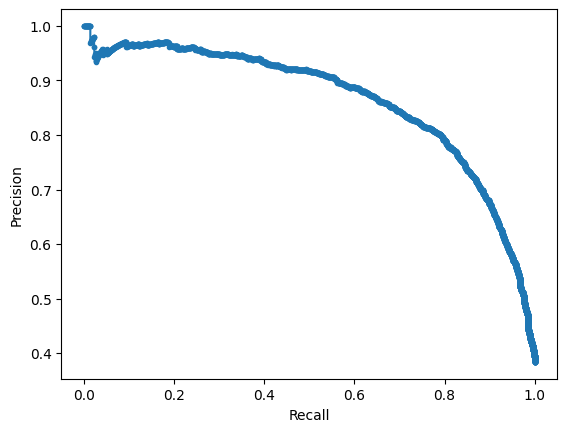

NAICS 23
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4122
           1       0.85      0.69      0.76      1479

    accuracy                           0.89      5601
   macro avg       0.88      0.82      0.84      5601
weighted avg       0.89      0.89      0.88      5601



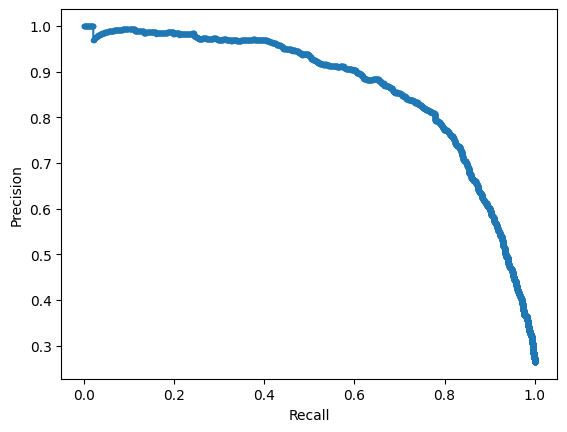

NAICS 33
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4638
           1       0.77      0.47      0.58       963

    accuracy                           0.88      5601
   macro avg       0.83      0.72      0.76      5601
weighted avg       0.88      0.88      0.87      5601



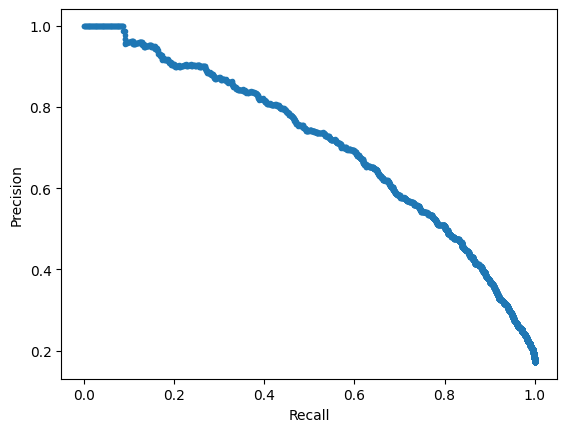

NAICS 56
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4475
           1       0.77      0.42      0.54      1126

    accuracy                           0.86      5601
   macro avg       0.82      0.69      0.73      5601
weighted avg       0.85      0.86      0.84      5601



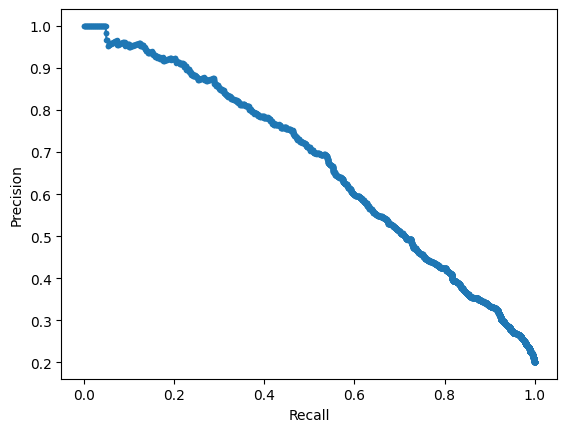

NAICS 42
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      4939
           1       0.71      0.23      0.35       662

    accuracy                           0.90      5601
   macro avg       0.81      0.61      0.65      5601
weighted avg       0.88      0.90      0.87      5601



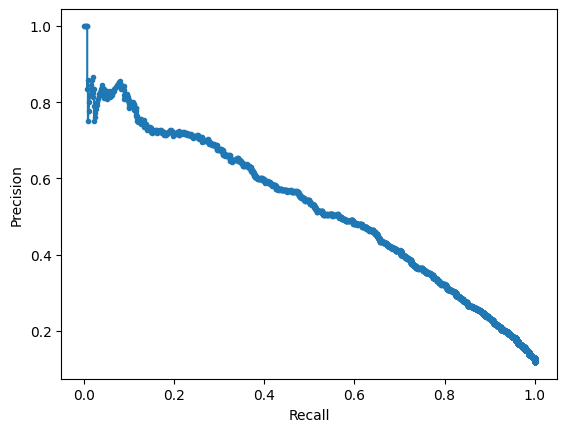

NAICS 48
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5257
           1       0.83      0.31      0.45       344

    accuracy                           0.95      5601
   macro avg       0.89      0.65      0.71      5601
weighted avg       0.95      0.95      0.94      5601



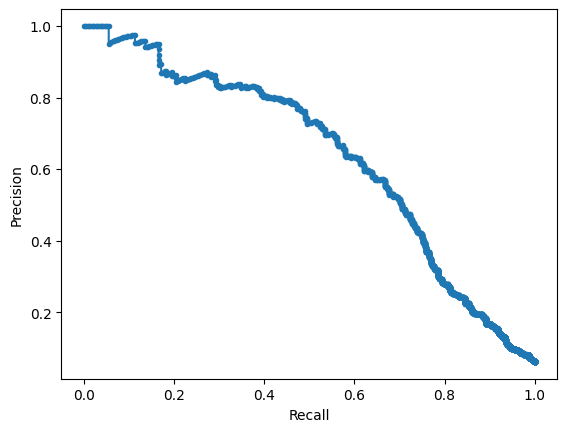

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

for naics in ["54", "23", "33", "56", "42", "48"]:
    y = df[naics].apply(lambda x: 0 if x == 0 else 1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model = Pipeline(
        [
            ("tfidf", TfidfVectorizer()),
            ("clf", LogisticRegression()),
        ]
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"NAICS {naics}")
    print(classification_report(y_test, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plot_precision_recall(y_test, y_pred_proba)

The results are good for negative class, but not so good for the positive class. We will try to improve the model by resampling the data.


### Logistic Regression with TF-IDF and subsampling


NAICS 54
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3451
           1       0.76      0.82      0.79      2150

    accuracy                           0.83      5601
   macro avg       0.82      0.83      0.83      5601
weighted avg       0.84      0.83      0.83      5601



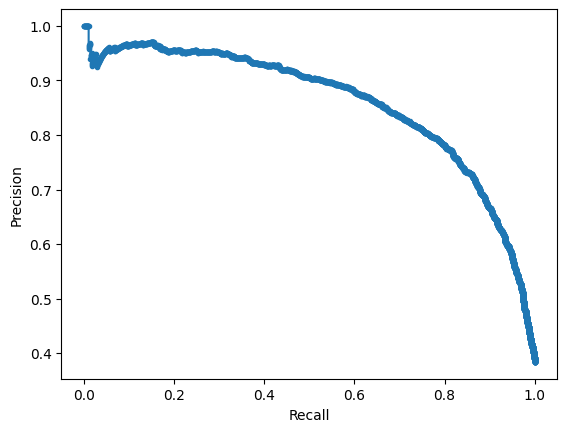

NAICS 23
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      4122
           1       0.72      0.83      0.77      1479

    accuracy                           0.87      5601
   macro avg       0.83      0.86      0.84      5601
weighted avg       0.88      0.87      0.87      5601



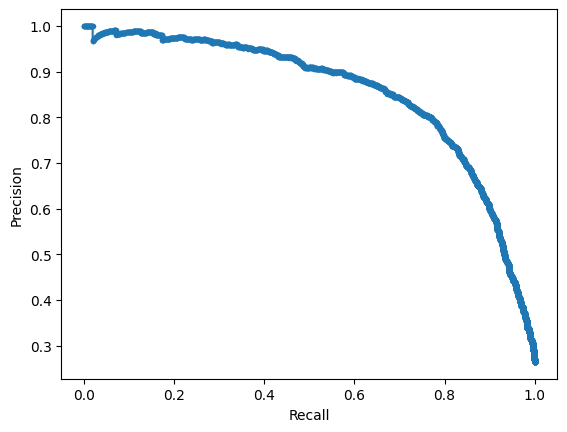

NAICS 33
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4638
           1       0.46      0.82      0.59       963

    accuracy                           0.80      5601
   macro avg       0.71      0.81      0.73      5601
weighted avg       0.87      0.80      0.82      5601



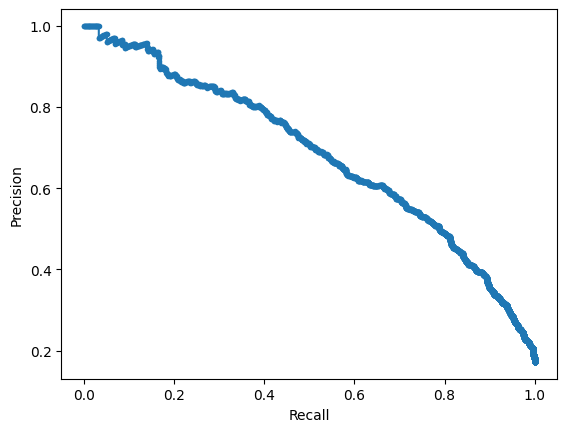

NAICS 56
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4475
           1       0.46      0.73      0.57      1126

    accuracy                           0.77      5601
   macro avg       0.69      0.76      0.71      5601
weighted avg       0.83      0.77      0.79      5601



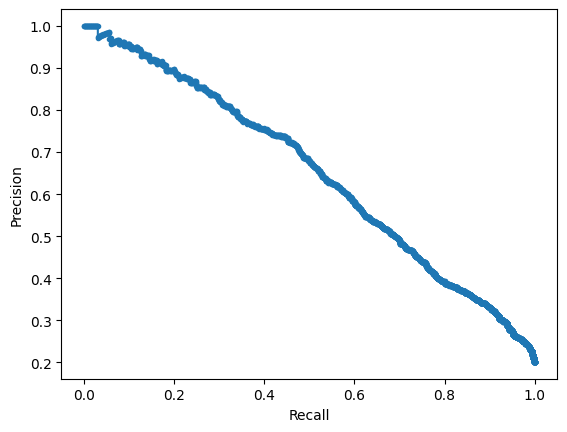

NAICS 42
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      4939
           1       0.32      0.78      0.45       662

    accuracy                           0.78      5601
   macro avg       0.64      0.78      0.65      5601
weighted avg       0.89      0.78      0.81      5601



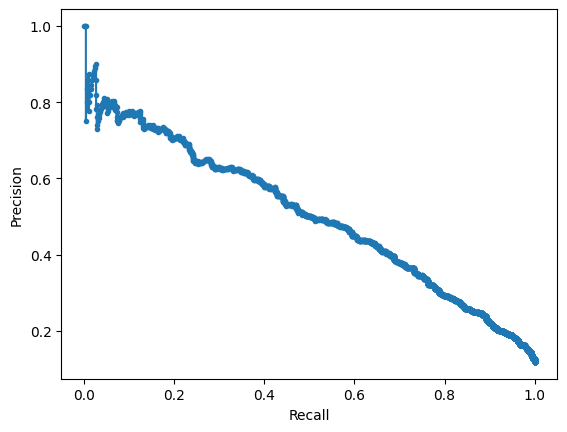

NAICS 48
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5257
           1       0.29      0.79      0.42       344

    accuracy                           0.87      5601
   macro avg       0.64      0.83      0.67      5601
weighted avg       0.94      0.87      0.89      5601



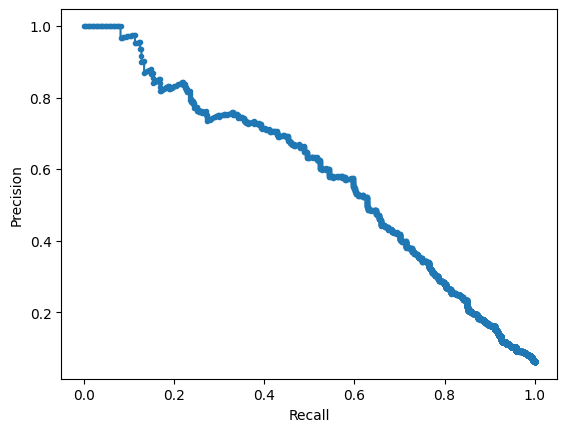

In [10]:
from sklearn.utils import resample

for naics in ["54", "23", "33", "56", "42", "48"]:
    y = df[naics].apply(lambda x: 0 if x == 0 else 1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # subsampling for train majority class
    majority = 0
    n_true = y_train.sum()
    # resample the majority class
    X_train_majority = X_train[y_train == majority]
    y_train_majority = y_train[y_train == majority]
    X_train_minority = X_train[y_train != majority]
    y_train_minority = y_train[y_train != majority]

    X_train_majority_resampled, y_train_majority_resampled = resample(
        X_train_majority, y_train_majority, n_samples=n_true, random_state=42
    )

    X_train_resampled = pd.concat([X_train_majority_resampled, X_train_minority])
    y_train_resampled = pd.concat([y_train_majority_resampled, y_train_minority])

    model = Pipeline(
        [
            ("tfidf", TfidfVectorizer()),
            ("clf", LogisticRegression()),
        ]
    )

    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(f"NAICS {naics}")
    print(classification_report(y_test, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plot_precision_recall(y_test, y_pred_proba)

By subsampling the negative class, we did not improve the model, so resampling doesn't seem to be useful.


## SVM with TF-IDF

Now let's use SVM, as it is the model that worked the best in the all 2 digit naics notebook.


In [15]:
X = df["BUSINESS_DESCRIPTION_PREPROCESSED"]
y = df["54"].apply(lambda x: 0 if x == 0 else 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
from sklearn.model_selection import GridSearchCV

model = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", SVC()),
    ]
)
param_grid = {
    "clf__C": [0.1, 1, 2],
    "clf__kernel": ["linear"],
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'clf__C': 1, 'clf__kernel': 'linear'}

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3444
           1       0.82      0.75      0.78      2157

    accuracy                           0.84      5601
   macro avg       0.84      0.82      0.83      5601
weighted avg       0.84      0.84      0.84      5601



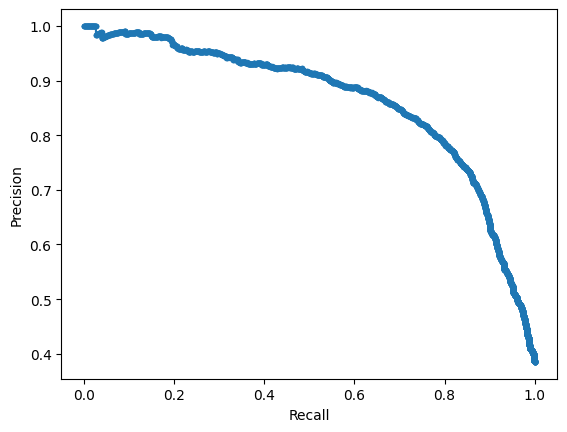

In [18]:
model = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", SVC(C=1, kernel="linear")),
    ]
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
y_pred_proba = model.decision_function(X_test)
plot_precision_recall(y_test, y_pred_proba)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     13809
           1       0.91      0.84      0.87      8591

    accuracy                           0.90     22400
   macro avg       0.91      0.89      0.90     22400
weighted avg       0.90      0.90      0.90     22400



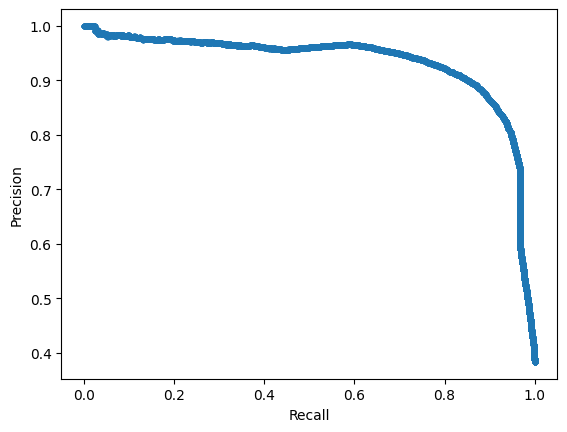

In [19]:
y_pred_train = model.predict(X_train)
print(classification_report(y_train, y_pred_train))
y_pred_proba_train = model.decision_function(X_train)
plot_precision_recall(y_train, y_pred_proba_train)

This model has a quite similar performance to the logistic regression model, so for simplicity and time reasons, we will use the logistic regression model.


## Conclusions


It seems that the model is not able to learn the patterns of the positive class. The performance of the models are better than trying to predict all classes at once in accuracy, but the precision and recall are still low.

It is possible that the model is not able to learn the patterns of the positive class because the descriptions are too short and not informative enough.
